<a href="https://colab.research.google.com/github/brianosmith/EXSY_fitting_notebook/blob/master/Fluoresence_data_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fluoresence data fitting for DAUDA binding and displacement assays

## Least squares linear combination of free and bound spectra

An approach to DAUDA binding and ligand displacement assays using python to achieve least squares fitting of a linear combination of the free and fully bound DAUDA spectra to spectra from a titration.

The least_sq approach is drawn from [Nicolas Coca's towardsdatascience post](https://towardsdatascience.com/classical-least-squares-method-for-quantitative-spectral-analysis-with-python-1926473a802c). The plotting with residuals is inspired by [David Pine's PyMan manual chaper 8](https://physics.nyu.edu/pine/pymanual/html/chap8/chap8_fitting.html) (see also the Gaussian fitting example below).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  # for unequal plot boxes
from numpy.linalg import inv
import scipy.optimize


def least_sq(sample_spectrum, components):
  # sample_spectrum (unknown spectrum): array of w values.
  # components (known spectra): array of n (number of components) columns with w values.
  # This def returns an array of n values. Each value is the similarity score for the sample_spectrum and a component spectrum.
  similarity = np.dot(inv(np.dot(components, components.T)) , np.dot(components, sample_spectrum))
  return similarity



In [ ]:
#load files

from google.colab import files
uploaded = files.upload()


[0.38397138 0.61971142]


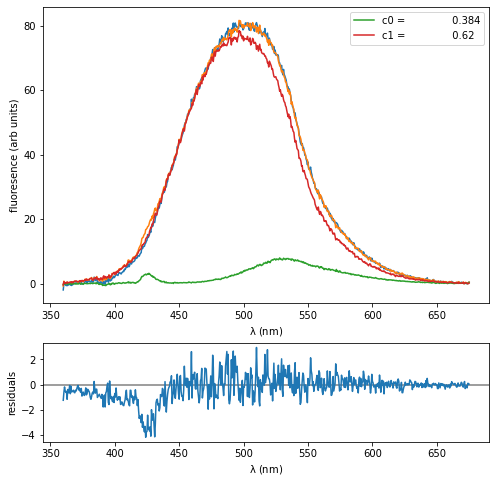

In [2]:
# read in buffer only spectrum and DAUDA in buffer data file
# l=wavelength, I=fluoresence intensity
bl, bI = np.loadtxt("MOPR0002.SP", skiprows=54, unpack=True)
sl, sI = np.loadtxt("MOPR0003.SP", skiprows=54, unpack=True)
#l = sl             # assuming that the spectra all have the same wavelengths
#subtract the baseline
iFree = np.subtract(sI, bI)
#make a smoothed version?

# read in DAUDA fully bound data file
# l=wavelength, I=fluoresence intensity
sl, sI = np.loadtxt("MOPR0016.SP", skiprows=54, unpack=True)
#l = sl
#subtract the baseline
iBound = np.subtract(sI, bI)
#need to add scaling for dilution
#make a smoothed version?

# read in spectrum from data file to be fitted
# l=wavelength, I=fluoresence intensity
sl, sI = np.loadtxt("MOPR0008.SP", skiprows=54, unpack=True)
l = sl
#subtract the baseline
iToFit = np.subtract(sI, bI)
#need to add scaling for dilution

#trim all spectra to remove most scattering affected part below 450 nm?

# make components array containing the free DAUDA and fully bound DAUDA spectra
components = np.array([iFree, iBound])

#apply least squares fit of free and bound to spectrum to be fitted
cs = least_sq(iToFit, components)

# cs contains the relative weightings of free and bound
print(cs)

# Create a figure window to plot data
fig = plt.figure(1, figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2])

# Top plot: data and fit
ax1 = fig.add_subplot(gs[0])
ax1.plot(l, iToFit)
ax1.plot(l, np.dot(cs, components))

for i in np.arange(len(cs)):
    plt.plot(l, cs[i]*components[i], label = 'c' + str(i)+ ' =               ' + str(np.round(cs[i], 3)))

ax1.set_xlabel(r'$\mathregular{\lambda}$ (nm)')
ax1.set_ylabel('fluoresence (arb units)')
plt.legend()

# Bottom plot: residuals
ax2 = fig.add_subplot(gs[1])
ax2.plot(l, iToFit - np.dot(cs, components))
ax2.axhline(color="gray", zorder=-1)
ax2.set_xlabel(r'$\mathregular{\lambda}$ (nm)')
ax2.set_ylabel('residuals')

plt.show()

###Factory version for multiple files


fitted Kd:  1.2340413013302229e-05 +- 2.5213868568037363e-06


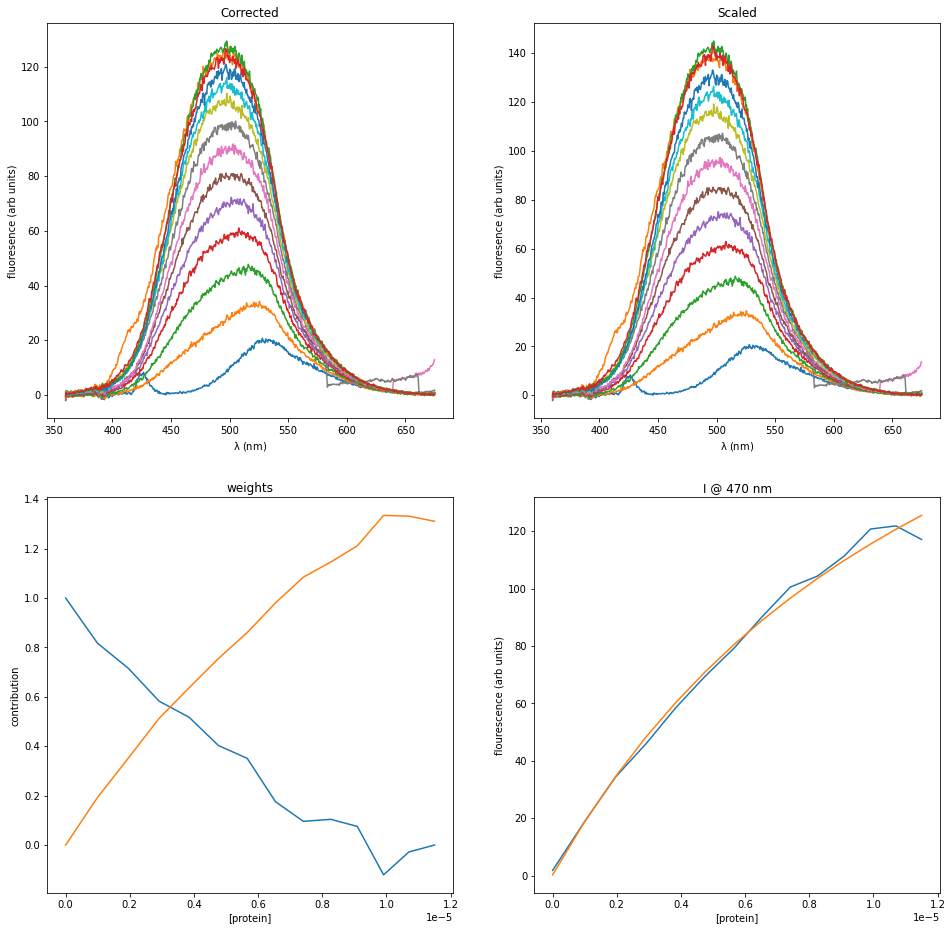

In [21]:
from math import sqrt

# read a CSV file with filenames, volumes, varied protein/ligand concentrations
# CSV has a header row which will become column names of the dataframe
datasets = pd.read_csv('file_volume_ligand_protein.csv')

# buffer, DAUDA alone & fully saturated filenames
bufferFileName = 'MOPR0002.SP'
startFileName = 'MOPR0003.SP'
endFileName = 'MOPR0016.SP'

# read buffer, DAUDA alone & fully saturated intensity values & subtract buffer
bl, bI = np.loadtxt(bufferFileName, skiprows=54, unpack=True)
l = bl             # assuming that the spectra all have the same wavelengths

fl, fI = np.loadtxt(startFileName, skiprows=54, unpack=True)
sl, sI = np.loadtxt(endFileName, skiprows=54, unpack=True)

iF = np.subtract(fI, bI)
iBound = np.subtract(sI, bI)

# scale fully saturated intensity values for change in volume
iB = iBound * (2.0/2.32)

# read data file intensity values
datasets['raw'] = np.array    # add an empty column to the dataframe
for row in datasets.itertuples():
   dl, dI = np.loadtxt(row.filename, skiprows=54, unpack=True)
   datasets.at[row.Index, 'raw'] = dI

# subtract the baseline intensity values
datasets['corr'] = np.array    # add an empty column to the dataframe
for row in datasets.itertuples():
   cI = row.raw - bI
   datasets.at[row.Index, 'corr'] = cI

# plot data file intensity values
fig = plt.figure(1, figsize=(16,16))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0,0])

for row in datasets.itertuples():
    plt.plot(l, row.corr)

ax1.set_title('Corrected')
ax1.set_xlabel(r'$\mathregular{\lambda}$ (nm)')
ax1.set_ylabel('fluoresence (arb units)')

# for fitting free and bound contributions we will need to scale by the dilution
# factor for each spectrum
# This also applies if extracting peak height or I470 for fitting
datasets['scaled'] = np.array    # add an empty column to the dataframe
for row in datasets.itertuples():
   scI = row.corr * (row.volume/2.0)
   datasets.at[row.Index, 'scaled'] = scI

# plot scaled (for volume change) intensity values
ax2 = fig.add_subplot(gs[0,1])

for row in datasets.itertuples():
    plt.plot(l, row.scaled)

ax2.set_title('Scaled')
ax2.set_xlabel(r'$\mathregular{\lambda}$ (nm)')
ax2.set_ylabel('fluoresence (arb units)')

# fit components to scaled 
datasets['components'] = np.array    # add an empty column to the dataframe
components = np.array([iF, iB])
for row in datasets.itertuples():
   cs = least_sq(row.scaled, components)
   datasets.at[row.Index, 'components'] = cs

#plot components vs varied [protein]
ax3 = fig.add_subplot(gs[1,0])

protein = []
free = []
bound = []
for row in datasets.itertuples():
   #print(row.protein, row.components[0])
   protein.append(row.protein)
   free.append(row.components[0])
   bound.append(row.components[1])

plt.plot(protein, free)
plt.plot(protein, bound)

ax3.set_title('weights')
ax3.set_xlabel('[protein]')
ax3.set_ylabel('contribution')

# extract intensity at fexed wavelength
datasets['iLambda'] = np.array    # add an empty column to the dataframe
indexOfLambda = np.where(l == 470)
for row in datasets.itertuples():
   iLambda = row.scaled[indexOfLambda]
   datasets.at[row.Index, 'iLambda'] = iLambda

#plot i470 vs varied [protein]
ax4 = fig.add_subplot(gs[1,1])

#protein = []
#free = []
#bound = []
#for row in datasets.itertuples():
#   #print(row.protein, row.components[0])
#   protein.append(row.protein)
#   free.append(row.components[0])
#   bound.append(row.components[1])

plt.plot(datasets.protein, datasets.iLambda)

ax4.set_title('I @ 470 nm')
ax4.set_xlabel('[protein]')
ax4.set_ylabel('flourescence (arb units)')

# For fitting fractional saturation we will need the "constant" [protein] or [ligand]
# as a function of the "varied" one in the response curve to handle dilution
# see https://colab.research.google.com/drive/1cyacoAS5_9UQD6pxcT09EhnHGNxbJRix?usp=sharing

def fracSatTitrated(Lvals, Kd, M0, Ls):
  # Function to simulate titrated saturation curve with increasing volume
  # Lvals is an array of deliberately varied component concentrations used
  # M0 is the initial concentration of the non-varied component
  # Ls is the ligand stock solution concetration to allow the volume change compensation
  # Kd is the Kd (supply an initial estimate for fitting)
  # returns an array of fractional saturation values

  Ys = []
  for L in Lvals:
    Y = ((M0*(1-(L/Ls)) + L + Kd) - sqrt((M0*(1-(L/Ls)) + L + Kd)**2 - (4 * M0*(1-(L/Ls)) * L)))/(2 * M0*(1-(L/Ls)))
    Ys.append(Y)
    
  Ys = np.array(Ys)
  return Ys

def makeResponseTitrated(Mzero, Lstock):
  # Allows a case specific responseTitrated() to be defined for curve_fit since
  # can't pass "fixed" args with args=()
  # If Q0 is known (a common case) adjust these defs to shift it
  def responseTitrated(Lvals, Kd, Qmax, Q0):
    # Function to wrap fracSatTitrated within an arbitrary response scale
    # Q0 and Qmax are the limits of the response and can be left unconstrained for fitting
    # Pass sensible guesses for Kd, Qmax & Q0 with p0=[] when using scipy.optimize
    # returns an array of response values
    M0 = Mzero
    Ls = Lstock

    Ys = fracSatTitrated(Lvals, Kd, M0, Ls)
    Qs = ((Qmax-Q0)*Ys) + Q0
    
    return Qs

  return responseTitrated

# fit using scipy.optimize.curve_fit
# e.g. for the intensity at 470 nm values
M0 = 1.0e-6; Ls = 1e-4 # known initial non-varied (DAUDA) conc and varied (protein) stock conc
Kd0 = 1.0e-6; Qmax0 = 200; Q00 = 0 # initial guesses for fitted params
nlfit, nlpcov = scipy.optimize.curve_fit(makeResponseTitrated(M0, Ls),
                datasets.protein, datasets.iLambda, p0=[Kd0, Qmax0, Q00])

fittedKd, fittedQmax, fittedQ0 = nlfit
dKd, dQmax, dQ0 = [np.sqrt(nlpcov[j,j]) for j in range(nlfit.size)]
print('fitted Kd: ', fittedKd,'+-',dKd)

#create fitted function
myResponseTitrated = makeResponseTitrated(M0, Ls)
fitiLs = myResponseTitrated(datasets.protein, fittedKd, fittedQmax, fittedQ0)

#add fitted values to last plot
plt.plot(datasets.protein, fitiLs)

## Alternative approach fitting Gaussian lines
This approach is attractive, but the free and bound DAUDA emission spectra are not single Gaussians (see e.g. [Mocanu, Ionita & Matei (2020)](https://doi.org/10.1016/j.saa.2020.118413)) so probably a better approach would be to generate a synthetic spectrum from each state by fitting Gaussians and then using that in the linear combination of components approach above.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  # for unequal plot boxes
from numpy.linalg import inv
import scipy.optimize


def Gauss(x, intensity, mu, sigma):
  # x is an array
  # mu is the expected value
  # sigma is the square root of the variance
  # intensity is a multiplication factor
  # This def returns the Gaussian function of x
  return intensity/(sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mu)/sigma)**2)

def twoGauss(x, I0, mu0, sigma0, I1, mu1, sigma1):
  # x is an array
  # Ps are intensity scaling factors
  # fps are centres
  # fws are widths (standard deviation)
  return I0/(sigma0 * np.sqrt(2*np.pi))*np.exp(-0.5*((x-mu0)/sigma0)**2) \
       + I1/(sigma1 * np.sqrt(2*np.pi))*np.exp(-0.5*((x-mu1)/sigma1)**2)


Text(0, 0.5, 'fluoresence (arb units)')

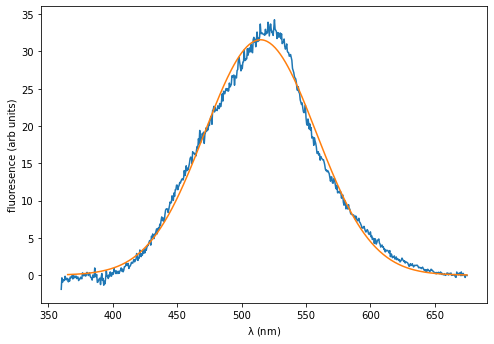

In [ ]:
# read in baseline and spectrum from data file
# l=wavelength, I=fluoresence intensity
bl, bI = np.loadtxt("MOPR0002.SP", skiprows=54, unpack=True)
sl, sI = np.loadtxt("MOPR0004.SP", skiprows=54, unpack=True)
l = sl
I = np.subtract(sI, bI)


#initial guesses for fitting parameters
intensity0, mu0, sigma0 = 100., 500., 10.

# fit data using SciPy's Levenberg-Marquart method
nlfit1, nlpcov1 = scipy.optimize.curve_fit(Gauss,
                l, I, p0=[intensity0, mu0, sigma0])
#nlfit2, nlpcov2 = scipy.optimize.curve_fit(twoGauss,
#                l, I, p0=[intensity0, mu0, sigma0, intensity0, mu0, sigma0])

#unpack fitting parameters
intensityFit, muFit, sigmaFit  = nlfit1
#intensityFit1, muFit1, sigmaFit1, intensityFit2, muFit2, sigmaFit2  = nlfit2


#create fitted function
l_fit = np.linspace(365.0, 675.0, 311)
I_fit1 = Gauss(l_fit, intensityFit, muFit, sigmaFit)
#I_fit2 = twoGauss(l_fit, intensityFit1, muFit1, sigmaFit1, intensityFit2, muFit2, sigmaFit2)
#I_fit2_1 = Gauss(l_fit, intensityFit1, muFit1, sigmaFit1)
#I_fit2_2 = Gauss(l_fit, intensityFit2, muFit2, sigmaFit2)

# Create figure window to plot data
fig = plt.figure(1, figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2])

# Top plot: data and fit
ax1 = fig.add_subplot(gs[0])
ax1.plot(l, I)
ax1.plot(l_fit, I_fit)
#ax1.plot(l_fit, I_fit2)
#ax1.plot(l_fit, I_fit2_1)
#ax1.plot(l_fit, I_fit2_2)
ax1.set_xlabel(r'$\mathregular{\lambda}$ (nm)')
ax1.set_ylabel('fluoresence (arb units)')
